# Training CNNs with Optional Autoencoder Denoising

#### *training CNNs where inputs can be toggle between regular image and reconstruction*

Install dependent libraries (uncomment and run once)

In [1]:
# !pip install utm
# !pip install torchvision 
# !pip install einops
# !pip install opencv-python

### Load Data

In [2]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
import imageio.plugins.ffmpeg as ffmpeg

Load, label, and split data into training and testing sets

In [3]:
#Loading the data and splitting it in testing and training data
from io import StringIO
import numpy as np
import csv
import math
import utm
import os

from sklearn.model_selection import train_test_split

# Cue up folders to check (MODIFY with addition or removal of folders)
data_folders = ['a1/','a2/','a3/','a4/','a5/','d1/','d2/','d3/','d4/','r3/','r4/','s1/']

# Sets to be filled
labels = []
images = []

# Read and format each folder in cue
for folder in data_folders:

    # Load image filenames
    img_path = './data/' + folder
    img_filenames = os.listdir(img_path)

    # Load CSV data
    csv_path = img_path + "/im_info.csv"
    with open(csv_path, 'r') as x:
            # csv_data = list(csv.reader(x, delimiter=","))
            reader_obj = list(csv.reader(x, delimiter=","))
            data = []
            for row in reader_obj:
                data.append(row)
            csv_data = list(data)
                
    # Load data into np array and delete title row element
    csv_data = np.array(csv_data, dtype=object)
    csv_data = np.delete(csv_data,0,axis=0)
    
    # Begin formatting data
    print('Formatting Data for', folder ,'...')
    print('Number of datapoints:', len(img_filenames))

    for i in range(0,len(csv_data)-2): #csv_data
        # Load image
        image = img_path+img_filenames[i]
        if '.csv' in image: continue
        if '.ipynb_checkpoints' in image: continue
        
        # Load current data and data 1/3s into future (for next imgage)
        # Vals loaded from each line are [timestamp, yaw, lat, lon]
        curr_line = csv_data[i]
        curr_vals =  np.float_([curr_line[1],curr_line[4],curr_line[6],curr_line[7]])
        next_line = csv_data[i+1]
        next_vals =  np.float_([next_line[1],next_line[4],next_line[6],next_line[7]])
    
        curr_coord = utm.from_latlon(curr_vals[2], curr_vals[3])
        next_coord = utm.from_latlon(next_vals[2], next_vals[3])
    
        # time_change = next_vals[0] - curr_vals[0] # change in time
        time_change = 0.33 # approximately 3 datapoints taken per second. Could not to exact time change because of rounding
        angle_change = next_vals[1] - curr_vals[1] # change that should be commanded to current steering angle
        distance_change = abs(math.dist([curr_coord[0],curr_coord[1]],[next_coord[0],next_coord[1]]))
        velocity = distance_change/time_change # velocity that should be commanded
    
        label = [angle_change, velocity] # angle change is in degrees (I think), velocity units are __
        if label[0] < 100 and label[0] > -100: # ADDED to remove outliers
            images.append(image)
            labels.append(label)

data_images = np.array(images)
data_labels = np.array(labels)

print('Formatting Complete')
print('=============================')

# Split data into training and testing sets
img_train, img_test, label_train, label_test = train_test_split(data_images, data_labels, test_size=0.2, random_state=42)

# Print the size of the resulting datasets
print(f"Training image data size: {len(img_train)}")
print(f"Testing image data size: {len(img_test)}")
print(f"Training label data size: {len(label_train)}")
print(f"Testing label data size: {len(label_test)}")


Formatting Data for a1/ ...
Number of datapoints: 117
Formatting Data for a2/ ...
Number of datapoints: 126
Formatting Data for a3/ ...
Number of datapoints: 133
Formatting Data for a4/ ...
Number of datapoints: 131
Formatting Data for a5/ ...
Number of datapoints: 133
Formatting Data for d1/ ...
Number of datapoints: 359
Formatting Data for d2/ ...
Number of datapoints: 420
Formatting Data for d3/ ...
Number of datapoints: 382
Formatting Data for d4/ ...
Number of datapoints: 444
Formatting Data for r3/ ...
Number of datapoints: 545
Formatting Data for r4/ ...
Number of datapoints: 525
Formatting Data for s1/ ...
Number of datapoints: 584
Formatting Complete
Training image data size: 3057
Testing image data size: 765
Training label data size: 3057
Testing label data size: 765


View data labels characteristics

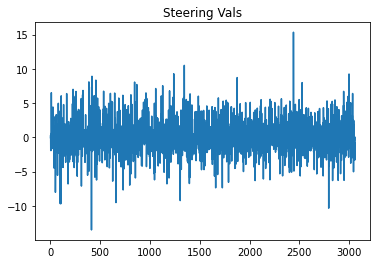

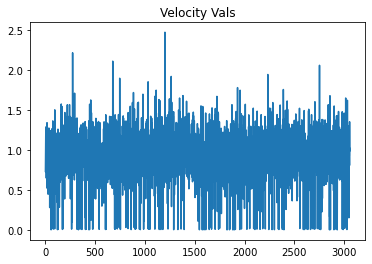

In [4]:
import matplotlib.pyplot as plt

i = 1
xVals = []
yVals = []
for lbl in label_train:
    # if lbl[0] < 100 and lbl[0] > -100:
    yVals.append(lbl[0])
    xVals.append(i)    
    i += 1
plt.plot(xVals,yVals)
plt.title("Steering Vals")
plt.show()
         
i = 1
xVals = []
yVals = []
for lbl in label_train:
    yVals.append(lbl[1])
    xVals.append(i)    
    i += 1
plt.plot(xVals,yVals)
plt.title("Velocity Vals")
plt.show()
         

## Define Transforms

**BASIC TRANSFORM (Resize, CenterCrop)**

Modified with normalizations, recoloring to observe performance of various transforms

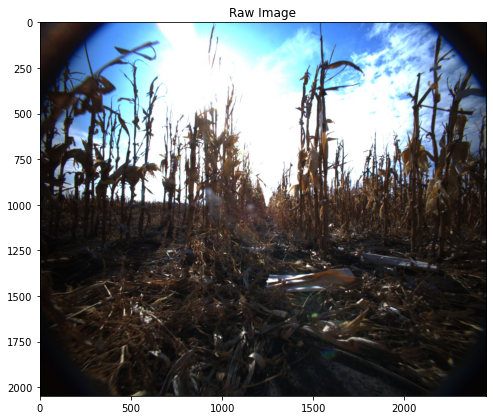

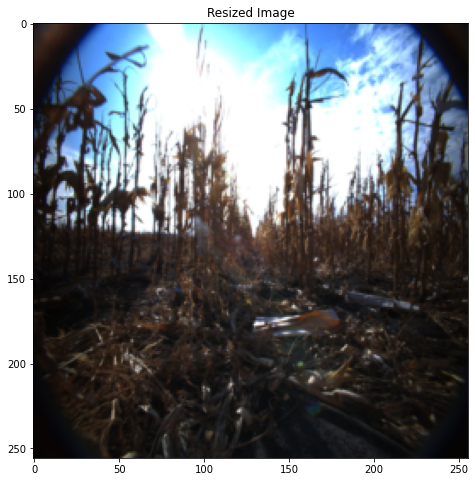

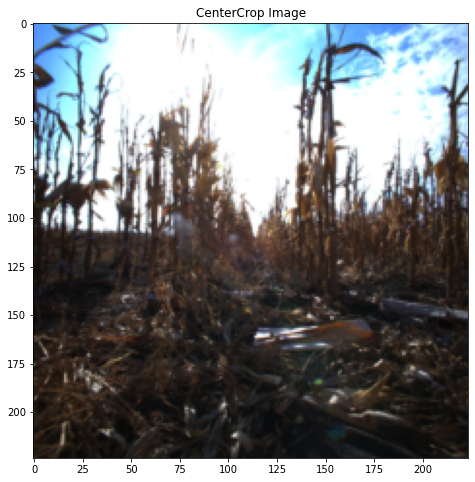

In [5]:
# BASIC TRANSFORM
import torch
import torchvision
from PIL import Image
import random

# !pip install torchvision
from torchvision import datasets, transforms
# from torchvision import datapoints

# Select a random image from the list
img_rand = random.randint(0,len(img_train))
image_path = img_train[img_rand]

image = Image.open(image_path)

# Raw Image
fig = plt.figure(figsize=(8,8))
plt.imshow(image)
plt.title('Raw Image')
plt.show

# First Transform
transform=transforms.Compose([
            transforms.Resize((256,256))])

fig = plt.figure(figsize=(8,8))
plt.imshow(transform(image))
plt.title('Resized Image')
plt.show

# Second Transform
transform=transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224)])
            # transforms.ToTensor()])

fig = plt.figure(figsize=(8,8))
plt.imshow(transform(image))
plt.title('CenterCrop Image')
plt.show

#Full Basic transform, with tensor
transform_basic=transforms.Compose([
    transforms.Resize(256),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.CenterCrop(224),
    transforms.ToTensor()
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]) 

**TRAPEZOIDAL CROP**

<function matplotlib.pyplot.show(close=None, block=None)>

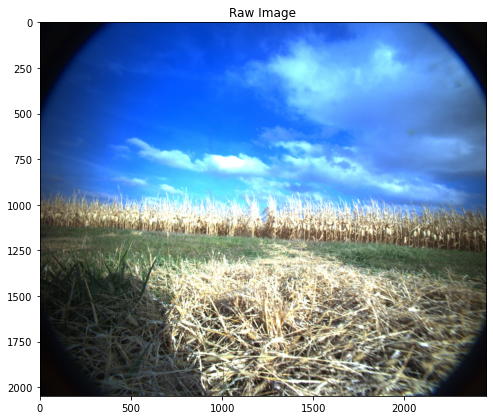

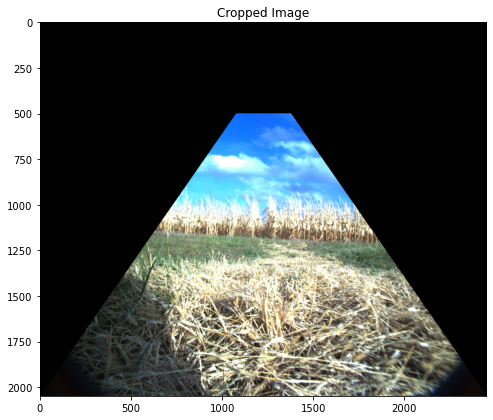

In [6]:
import torch
import torchvision
from PIL import Image, ImageDraw
import numpy as np
from torchvision import datasets, transforms

# Define the trapezoid shape crop
def trapezoid_crop(img, trap_height, trap_top_width, trap_bottom_width):
    width, height = img.size
    top_left = (width / 2 - trap_top_width / 2, trap_height)
    top_right = (width / 2 + trap_top_width / 2, trap_height)
    bottom_left = (0, height)
    bottom_right = (width, height)
    trap_points = [top_left, top_right, bottom_right, bottom_left]
    trap_mask = Image.new('L', (width, height), 0)
    ImageDraw.Draw(trap_mask).polygon(trap_points, outline=1, fill=1)
    img_arr = np.array(img)
    img_arr = np.array(img_arr * np.expand_dims(np.array(trap_mask), axis=-1), dtype=np.uint8)
    img_cropped = Image.fromarray(img_arr)
    return img_cropped

# Select a random image from the list
img_rand = random.randint(0,len(img_train))
image_path = img_train[img_rand]

image = Image.open(image_path)

# Raw Image
fig = plt.figure(figsize=(8,8))
plt.imshow(image)
plt.title('Raw Image')
plt.show

# Apply trapezoid crop
trap_height = 500
trap_top_width = 300
trap_bottom_width = 800

image = trapezoid_crop(image, trap_height, trap_top_width, trap_bottom_width)

fig = plt.figure(figsize=(8,8))
plt.imshow(image)
plt.title('Cropped Image')
plt.show

**FULL TRANSFORM**

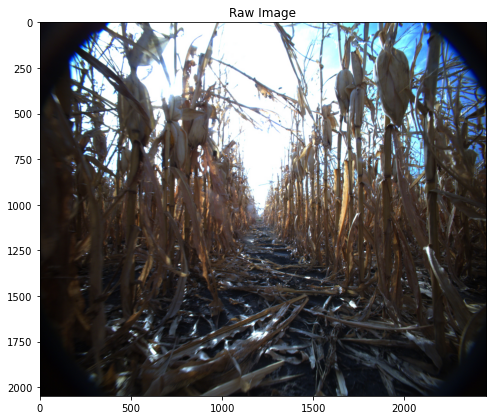

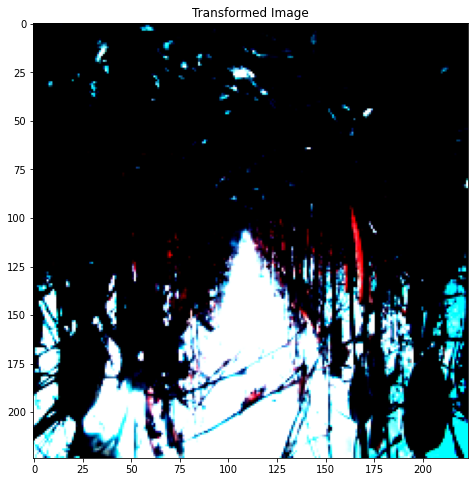

In [7]:
#Transformation (training the dataset by augmenting the dataset with more diverse images, making the models more robust to variations in the input data.)
#This code is used for image data augmentation,which helps in increasing the diversity of images in the dataset

# These transforms randomly rotate, flip horizontally and vertically, adjust brightness, contrast, saturation, hue, resize, center crop, convert to tensor, 
# and normalize the image pixel values.
transform_full = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Select a random image from the list
img_rand = random.randint(0,len(img_train))
image_path = img_train[img_rand]

image = Image.open(image_path)

# Raw Image
fig = plt.figure(figsize=(8,8))
plt.imshow(image)
plt.title('Raw Image')
plt.show

# Apply the transforms
image = transform_full(image)
image = np.clip(image, 0, 1)

# Display the transformed image
fig = plt.figure(figsize=(8,8))
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.title('Transformed Image')
plt.show()


# UNUSED: Generates directory of trapezoidal-cropped images for training
# import os

# # Create a new directory to store the transformed images
# if not os.path.exists('transformed'):
#     os.makedirs('transformed')

# # Count the number of transformed images
# num_transformed = 0

# # Loop over all images in the dataset and apply the transformation
# for i, image_path in enumerate(img_train):
#     # Check if the image has already been transformed and saved
#     if os.path.exists(os.path.join('transformed', 'img_{}.jpg'.format(i))):
#         continue

#     image = Image.open(image_path)

#     # Apply trapezoid crop
#     trap_height = 500
#     trap_top_width = 300
#     trap_bottom_width = 800

#     image = trapezoid_crop(image, trap_height, trap_top_width, trap_bottom_width)

#     # Apply the transforms
# #     image = transform_full(image)

#     # Save the transformed image
#     if 'RandomRotation' in transform_full.transforms.__str__() and 'RandomHorizontalFlip' in transform_full.transforms.__str__() and 'RandomVerticalFlip' in transform_full.transforms.__str__():
#         file_name = 'img_{}.jpg'.format(i)
#         save_path = os.path.join('transformed', file_name)
#         torchvision.utils.save_image(image, save_path)

#         # Increment the counter
#         num_transformed += 1

# # Display the total number of transformed images
# print('Transformed and saved {} images.'.format(num_transformed))


## Prepare Dataset Class

Custom dataloader, including boolean value for performing trapezoidal crop

In [8]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from PIL import Image

class MaizeRoverDataset(Dataset):
    def __init__(self, images, labels, transform=None, trap=False):
        # Normalize labels between 0 and 1
        temp_labels = labels
        norm_labels = []
        
        steer_max = 0
        steer_min = 0
        vel_max = 0
        vel_min = 0
        
        # Find min and max values for normalization
        for lbl in temp_labels:
            if lbl[0] > steer_max : steer_max = lbl[0]
            if lbl[0] < steer_min: steer_min = lbl[0]
            if lbl[1] > vel_max: vel_max = lbl[1]
            if lbl[1] < vel_min: vel_min = lbl[1]
            
        # Normalize all labels   
        for lbl in temp_labels:
            steer_norm = (lbl[0] - steer_min) / (steer_max - steer_min)
            vel_norm = (lbl[1] - vel_min) / (vel_max - vel_min)
            
            norm_labels.append([steer_norm, vel_norm])
        
        self.labels = np.array(norm_labels)
        self.images = images
        self.transform = transform    
        self.trap = trap
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        img_path = self.images[idx] # './data/IMG_data/' + self.images[idx]
        image = Image.open(img_path)
        label = self.labels[idx]
        
        # Apply trapezoid crop
        if self.trap:
            image = trapezoid_crop(image, 500, 300, 800)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


## Autoencoder Definitions

Autoencoders trained in IntraRow_Navigation_Autoencoders.ipynb

#### AE1

In [9]:
import torch.nn as nn

# The encoder will take the ground truth sample as input and project it down into some smaller latent representation.
class Encoder1(nn.Module):
    def __init__(self):
        super(Encoder1, self).__init__()
        self.c1 = nn.Conv2d(3, 16, 6, 3, 1) #in, out, kernal, stride, padding
        self.c2 = nn.Conv2d(16, 32, 16, 8, 1)
        self.l0 = nn.Linear(2048, 490)
        self.l1 = nn.Linear(490, 256)
        
    def forward(self, x):
        # print('Enc In:', x.shape)
        x = F.relu(self.c1(x))
        # print('Enc C1:', x.shape)
        x = self.c2(x)
        # print('Enc C2:', x.shape)
        x = x.flatten(1)
        # print('Enc Flat:', x.shape)
        x = self.l0(F.relu(x))
        # print('Enc L0:', x.shape)
        x = self.l1(F.relu(x))
        # print('Enc L1:', x.shape)
        return x
    
# The decoder will take the encoded latent representation as input and predict what the original input to the encoder block was
class Decoder1(nn.Module):
    def __init__(self):
        super(Decoder1, self).__init__()
        self.cT2 = nn.ConvTranspose2d(32, 16, 16, 8, 0, 2) #in, out, kernal, stride, in pad, out pad
        self.cT1 = nn.ConvTranspose2d(16, 3, 6, 3, 1, 1)
        self.l1 = nn.Linear(256, 490)
        self.l0 = nn.Linear(490, 2048)
        
    def forward(self, x):
        # print('Dec In:', x.shape)
        x = torch.sin(self.l1(x))
        # print('Dec L1:', x.shape)
        x = torch.sin(self.l0(x))
        # print('Dec L0:', x.shape)
        x = rearrange(x, 'b (c h w) -> b c h w', c=32, h=8, w=8)
        # print('Dec Rearrange:', x.shape)
        x = F.relu(self.cT2(x))
        # print('Dec cT2:', x.shape)
        x = self.cT1(x)
        # print('Dec cT1:', x.shape)
        return x
    
    
# For ease of use we package the encoder and decoder into a single module
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = Encoder1()
        self.decoder = Decoder1()
        
    def forward(self, x):
        latents = self.encoder(x)
        recon = self.decoder(latents)
        return recon, latents

#### AE2

In [10]:
# The encoder will take the ground truth sample as input and project it down into some smaller latent representation.
class Encoder2(nn.Module):
    def __init__(self):
        super(Encoder2, self).__init__()
        self.c1 = nn.Conv2d(3, 32, 3, 3, 1) #in, out, kernal, stride, padding
        self.c2 = nn.Conv2d(32, 64, 6, 3, 1)
        self.c3 = nn.Conv2d(64, 128, 10, 5, 1)
        self.l1 = nn.Linear(2048, 1024)
        self.l2 = nn.Linear(1024, 512)
        
    def forward(self, x):
        # print('Enc In:', x.shape)
        x = F.relu(self.c1(x))
        # print('Enc C1:', x.shape)
        x = F.relu(self.c2(x))
        # print('Enc C2:', x.shape)
        x = self.c3(x)
        # print('Enc C3:', x.shape)
        x = x.flatten(1)
        # print('Enc Flat:', x.shape)
        x = self.l1(F.relu(x))
        # print('Enc L1:', x.shape)
        x = self.l2(F.relu(x))
        # print('Enc L2:', x.shape)
        return x
    
# The decoder will take the encoded latent representation as input and predict what the original input to the encoder block was
class Decoder2(nn.Module):
    def __init__(self):
        super(Decoder2, self).__init__()
        self.cT3 = nn.ConvTranspose2d(128, 64, 10, 5, 1, 1) #in, out, kernal, stride, in pad, out pad
        self.cT2 = nn.ConvTranspose2d(64, 32, 6, 3, 0, 0)
        self.cT1 = nn.ConvTranspose2d(32, 3, 3, 3, 1, 1)
        self.l2 = nn.Linear(1024, 2048)
        self.l1 = nn.Linear(512, 1024)
        
    def forward(self, x):
        # print('Dec In:', x.shape)
        x = torch.sin(self.l1(x))
        # print('Dec L1:', x.shape)
        x = torch.sin(self.l2(x))
        # print('Dec L2:', x.shape)
        x = rearrange(x, 'b (c h w) -> b c h w', c=128, h=4, w=4)
        # print('Dec Rearrange:', x.shape)
        
        x = F.relu(self.cT3(x))
        # print('Dec cT3:', x.shape)
        x = F.relu(self.cT2(x))
        # print('Dec cT2:', x.shape)
        x = self.cT1(x)
        # print('Dec cT1:', x.shape)
        return x
    
    
# For ease of use we package the encoder and decoder into a single module
class AE2(nn.Module):
    def __init__(self):
        super(AE2, self).__init__()
        self.encoder = Encoder2()
        self.decoder = Decoder2()
        
    def forward(self, x):
        latents = self.encoder(x)
        recon = self.decoder(latents)
        return recon, latents

#### AE3

In [11]:
# The encoder will take the ground truth sample as input and project it down into some smaller latent representation.
class Encoder3(nn.Module):
    def __init__(self):
        super(Encoder3, self).__init__()
        self.c1 = nn.Conv2d(3, 32, 4, 2, 1) #in, out, kernal, stride, padding
        self.c2 = nn.Conv2d(32, 64, 4, 2, 1)
        self.c3 = nn.Conv2d(64, 128, 4, 2, 1)
        
    def forward(self, x):
        # print('Enc In:', x.shape)
        x = F.relu(self.c1(x))
        # print('Enc C1:', x.shape)
        x = F.relu(self.c2(x))
        # print('Enc C2:', x.shape)
        x = self.c3(x)
        # print('Enc C3:', x.shape)
        return x
    
# The decoder will take the encoded latent representation as input and predict what the original input to the encoder block was
class Decoder3(nn.Module):
    def __init__(self):
        super(Decoder3, self).__init__()
        self.cT3 = nn.ConvTranspose2d(128, 64, 4, 2, 1, 0) #in, out, kernal, stride, in pad, out pad
        self.cT2 = nn.ConvTranspose2d(64, 32, 4, 2, 1, 0)
        self.cT1 = nn.ConvTranspose2d(32, 3, 4, 2, 1, 0)
        
    def forward(self, x):
        # print('Dec In:', x.shape)
        x = F.relu(self.cT3(x))
        # print('Dec cT3:', x.shape)
        x = F.relu(self.cT2(x))
        # print('Dec cT2:', x.shape)
        x = self.cT1(x)
        # print('Dec cT1:', x.shape)
        return x
    
    
# For ease of use we package the encoder and decoder into a single module
class AE3(nn.Module):
    def __init__(self):
        super(AE3, self).__init__()
        self.encoder = Encoder3()
        self.decoder = Decoder3()
        
    def forward(self, x):
        #AE3
        latents = self.encoder(x)
        recon = self.decoder(latents)
        return recon, latents

#### AE4

In [12]:
# start off by defining multiple modules that encompass our autoencoder

# The encoder will take the ground truth sample as input and project it down into some smaller latent representation.
class Encoder4(nn.Module):
    def __init__(self):
        super(Encoder4, self).__init__()
        self.c1 = nn.Conv2d(3, 16, 3, 1, 1) #in, out, kernal, stride, padding
        self.c2 = nn.Conv2d(16, 32, 4, 2, 1)
        self.c3 = nn.Conv2d(32, 64, 4, 2, 1)
        self.c4 = nn.Conv2d(64, 128, 4, 2, 1)
        
    def forward(self, x):
        # print('Enc In:', x.shape)
        x = F.relu(self.c1(x))
        # print('Enc C1:', x.shape)
        x = F.relu(self.c2(x))
        # print('Enc C2:', x.shape)
        x = F.relu(self.c3(x))
        # print('Enc C3:', x.shape)
        x = self.c4(x)
        # print('Enc C4:', x.shape)
        return x
    
# The decoder will take the encoded latent representation as input and predict what the original input to the encoder block was
class Decoder4(nn.Module):
    def __init__(self):
        super(Decoder4, self).__init__()
        self.cT4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, 0) #in, out, kernal, stride, in pad, out pad
        self.cT3 = nn.ConvTranspose2d(64, 32, 4, 2, 1, 0)
        self.cT2 = nn.ConvTranspose2d(32, 16, 4, 2, 1, 0)
        self.cT1 = nn.ConvTranspose2d(16, 3, 3, 1, 1, 0)
        
    def forward(self, x):
        # print('Dec In:', x.shape)
        x = F.relu(self.cT4(x))
        # print('Dec cT4:', x.shape)
        x = F.relu(self.cT3(x))
        # print('Dec cT3:', x.shape)
        x = F.relu(self.cT2(x))
        # print('Dec cT2:', x.shape)
        x = self.cT1(x)
        # print('Dec cT1:', x.shape)
        return x
    
    
# For ease of use we package the encoder and decoder into a single module
class AE4(nn.Module):
    def __init__(self):
        super(AE4, self).__init__()
        self.encoder = Encoder4()
        self.decoder = Decoder4()
        
    def forward(self, x):
        latents = self.encoder(x)
        recon = self.decoder(latents)
        return recon, latents

## Define CNNs for Training

Simple 2-Convolution CNN (trained models called "simple" CNN)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class MaizeRoverCNN_Simple(nn.Module): # 2Layer
    def __init__(self):
        super(MaizeRoverCNN_Simple, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 6) #in channels, out channels, kernel size, stride (opt.)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(739600, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

3-Layer CNN (saved as 3Layer or Basic CNN)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


class MaizeRoverCNN_3Layer(nn.Module): # 3Layer 1
    def __init__(self):
        super(MaizeRoverCNN_3Layer, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3) #in channels, out channels, kernel size, stride (opt.)
        self.conv2 = nn.Conv2d(64, 128, 10, 8)
        self.conv3 = nn.Conv2d(128, 256, 10, 10)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256,64)
        self.fc4 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        # print('X Conv1:', x.shape)
        # x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv2(x))
        # print('X Conv2:', x.shape)
        x = F.relu(self.conv3(x))
        # print('X Conv3:', x.shape)
        
        x = torch.flatten(x,1)
        # print('X Flat:', x.shape)
        x = F.relu(self.fc1(x))
        # print('FC1:', x.shape)
        x = F.relu(self.fc2(x))
        # print('FC2:', x.shape)
        x = F.relu(self.fc3(x))
        # print('FC3:', x.shape)
        # x = F.relu(self.fc4(x))
        x = self.fc4(x)   
        # print('FC4:', x.shape)
        return x


Alternate 3-Layer CNN (named 3Layer 2 when referenced)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


class MaizeRoverCNN_3LayerAlt(nn.Module): # 3Layer 2
    def __init__(self):
        super(MaizeRoverCNN_3LayerAlt, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1) #in channels, out channels, kernel size, stride, pad
        self.conv2 = nn.Conv2d(64, 128, 8, 4, 1)
        self.conv3 = nn.Conv2d(128, 256, 12, 6, 1)
        self.fc0 = nn.Linear(2304, 1024)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256,64)
        self.fc4 = nn.Linear(64, 2)

    def forward(self, x):
        # print('X In:', x.shape)
        x = F.relu(self.conv1(x))
        # print('X Conv1:', x.shape)
        x = F.relu(self.conv2(x))
        # print('X Conv2:', x.shape)
        x = F.relu(self.conv3(x))
        # print('X Conv3:', x.shape)
        
        x = torch.flatten(x,1)
        # print('X Flat:', x.shape)
        x = F.relu(self.fc0(x))
        # print('FC0:', x.shape)
        x = F.relu(self.fc1(x))
        # print('FC1:', x.shape)
        x = F.relu(self.fc2(x))
        # print('FC2:', x.shape)
        x = F.relu(self.fc3(x))
        # print('FC3:', x.shape)
        # x = F.relu(self.fc4(x))
        x = self.fc4(x)   
        # print('FC4:', x.shape)
        return x


Experimental Model With Pooling (unused)

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class MaizeRoverCNN_Design(nn.Module):
    def __init__(self):
        super(MaizeRoverCNN_Design, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, (10,10)) #in channels, out channels, kernel size, stride (opt.)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 24, (24,24))
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(42336, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        
        
    def forward(self, x):      
            
        # print('X Init:',x.shape)
        x = self.pool1(F.relu(self.conv1(x)))
        # print('X Conv1, Pool1:', x.shape)
        x = self.pool2(F.relu(self.conv2(x)))
        # print('X Conv2, Pool2:', x.shape)
        
        # x = x.view(x.size()[0], -1)
        x = torch.flatten(x,1)
        # print('Flat:', x.shape)
        x = F.relu(self.fc1(x))
        # print('X FC1:', x.shape)
        x = F.relu(self.fc2(x))
        # print('X FC2:', x.shape)
        x = self.fc3(x)
        # print('X FC3:', x.shape)
        
        return x

## CNN Training
Define training parameters to use

In [17]:
# PAREMETERS FOR MODEL TRAINING
BATCH_SIZE = 32
EPOCHS = 5

# TRAINING AND VALIDATION SPLIT
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT

#Define image transform used
transform = transform_basic # transform_full or transform_basic

# Define path to trained autoencoder
RUN_WITH_AE = True # Toggle whether data is passed before autoencoder before being input into CNN for train/test
AE_PATH = 'ae3.pt'

Load data for training, validating, and testing models.

In [18]:
#Load Training and Testing Data
from torch.utils.data import DataLoader
from torch.utils.data import random_split
           
# load datasets
training_data = MaizeRoverDataset(img_train, label_train, transform, False)
test_data = MaizeRoverDataset(img_test, label_test, transform, False)

# do train/validation split
numTrainSamples = int(math.ceil(len(training_data) * TRAIN_SPLIT))
numValSamples = int(math.floor(len(training_data) * VAL_SPLIT))
print('TrainSamps:',numTrainSamples,'ValSamps:',numValSamples,
      'Total:', numTrainSamples+numValSamples)


(train_data, val_data) = random_split(training_data, 
                                    [numTrainSamples, numValSamples],
                                    generator=torch.Generator().manual_seed(42))

# New data loaders
train_loader =  DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader =  DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# calculate steps per epoch for training and validation set
trainSteps = len(train_loader.dataset) // BATCH_SIZE
valSteps = len(val_loader.dataset) // BATCH_SIZE
testSteps = len(test_loader.dataset) // BATCH_SIZE

TrainSamps: 2293 ValSamps: 764 Total: 3057


#### DO TRAINING

In [19]:
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# initialize model and training parameters
model =  MaizeRoverCNN_3Layer()
model.to(device)


print("Number of parameters: ", sum(p.numel() for p in model.parameters()))
# lossFn = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

lossFn = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5) 

# AE----------------------------------------------
if RUN_WITH_AE:
    ae = torch.load(AE_PATH)
    ae.eval()
    ae.to(device)
# ----------------------------------------------


# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"val_loss": []
}

# measure how long training is going to take
print("====Training the network====")
startTime = time.time()

n_minibatches = len(train_loader)

# ------------------START TRAINING LOOP------------------
for epoch in range(0,EPOCHS):    
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    
    running_loss = 0.0
    epoch_time = time.time()
    print_every = n_minibatches // 10
    # total_train_loss = 0
    
    print("EPOCH: {}/{}".format(epoch + 1, EPOCHS))
    print("==============================")
    
    # DO TRAINING
    # loop over training set
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # AE--------------------------------------------
        if RUN_WITH_AE:
            recon, latents = ae(inputs)
            inputs = recon
        # ----------------------------------------------
        
        model.train()
        
        # perform forward pass and calculate training loss
        pred = model(inputs)
        loss = lossFn(pred, labels.float())
        
        # zero gradients, do backprop, update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        
        # print every 10th of epoch
        if (i + 1) % (print_every + 1) == 0:    
            print("Epoch {}, {:d}% \t train_loss: {:.4f} took: {:.2f}s".format(
                epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                time.time() -epoch_time))
            running_loss = 0.0
            epoch_time = time.time()
        
        # add the loss to the total training loss so far
        totalTrainLoss += loss
        
    print('Training Step Done, Evaluating with Validation Data...')
    
    # EVALUATE WITH VALIDATION DATA
    # switch off autograd for evaluation
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        
        # loop over the validation set
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # AE--------------------------------------------
            if RUN_WITH_AE:
                recon, latents = ae(inputs)
                inputs = recon
            # ----------------------------------------------
            
            # make predictions and calculate the validation loss
            pred = model(inputs)
            totalValLoss += lossFn(pred, labels.float())
            
 
    # PRINT STATISTICS
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
        
	# update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    
	# print the model training and validation information
    print("Train loss: {:.6f}".format(avgTrainLoss))
    print("Val loss: {:.6f}\n".format(avgValLoss))

# ------------------END TRAINING LOOP------------------ 
    
# finish measuring how long training took
endTime = time.time()
print("====Training complete====")
print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))

Number of parameters:  4770882
====Training the network====
EPOCH: 1/5
Epoch 1, 11% 	 train_loss: 0.0939 took: 25.93s
Epoch 1, 22% 	 train_loss: 0.0193 took: 24.05s
Epoch 1, 33% 	 train_loss: 0.0116 took: 24.08s
Epoch 1, 44% 	 train_loss: 0.0086 took: 23.88s
Epoch 1, 55% 	 train_loss: 0.0081 took: 24.16s
Epoch 1, 66% 	 train_loss: 0.0070 took: 24.10s
Epoch 1, 77% 	 train_loss: 0.0062 took: 24.01s
Epoch 1, 88% 	 train_loss: 0.0073 took: 24.27s
Epoch 1, 100% 	 train_loss: 0.0073 took: 23.19s
Training Step Done, Evaluating with Validation Data...
Train loss: 0.016689
Val loss: 0.006290

EPOCH: 2/5
Epoch 2, 11% 	 train_loss: 0.0066 took: 22.66s
Epoch 2, 22% 	 train_loss: 0.0078 took: 22.71s
Epoch 2, 33% 	 train_loss: 0.0070 took: 22.66s
Epoch 2, 44% 	 train_loss: 0.0089 took: 22.72s
Epoch 2, 55% 	 train_loss: 0.0073 took: 22.61s
Epoch 2, 66% 	 train_loss: 0.0069 took: 22.63s
Epoch 2, 77% 	 train_loss: 0.0072 took: 22.68s
Epoch 2, 88% 	 train_loss: 0.0070 took: 22.68s
Epoch 2, 100% 	 train_

SAVE MODEL. **DEFINE NEW PATH NAME IF DIFFERENT MODEL WAS JUST TRAINED**

In [20]:
# Save entire model
# Specify a path
PATH = "ae3_toBasic.pt"

# Save
torch.save(model, PATH)

EVALUATE LOSS

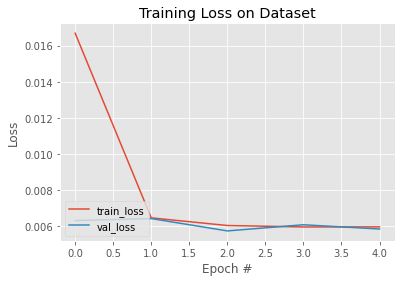

In [21]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

EVALUATE WITH TEST DATA

NOTE: PATH variable needs to have correct filename for whatever model we're testing

In [22]:
# ------------------RUN TEST DATA----------------------
import torch
import torchvision
from PIL import Image, ImageDraw
import numpy as np
from torchvision import datasets, transforms

NUM_SAMPLES = 5
print("Running Test Dataset")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PATH = "ae3_toBasic.pt"

#Load saved model
model = torch.load(PATH)
torch.no_grad()
model.eval()
model.to(device)


lossFn = nn.MSELoss()

#---------------------------------------
#Load saved autoencoder model
if RUN_WITH_AE:
    ae = torch.load(AE_PATH)
    ae.eval()
    ae.to(device)
#---------------------------------------

totalTestLoss = 0

# switch off autograd for evaluation
with torch.no_grad():
    # set the model in evaluation mode
    model.eval()
        
    # loop over the test set
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # AE DENOISING----------------------------------
        if RUN_WITH_AE:
            recon, latents = ae(inputs)
            inputs = recon
        # ----------------------------------------------
            
        # make predictions and calculate the test loss
        pred = model(inputs)
        totalTestLoss += lossFn(pred, labels.float())
        
# calculate the average test loss
avgTestLoss = totalTestLoss / testSteps
        
# print the model training and validation information
print("Test loss (average): {:.6f}".format(avgTestLoss))

Running Test Dataset
Test loss (average): 0.036200


LOSS OVER TEST DATASET - AE FRONT END

Running Test Dataset


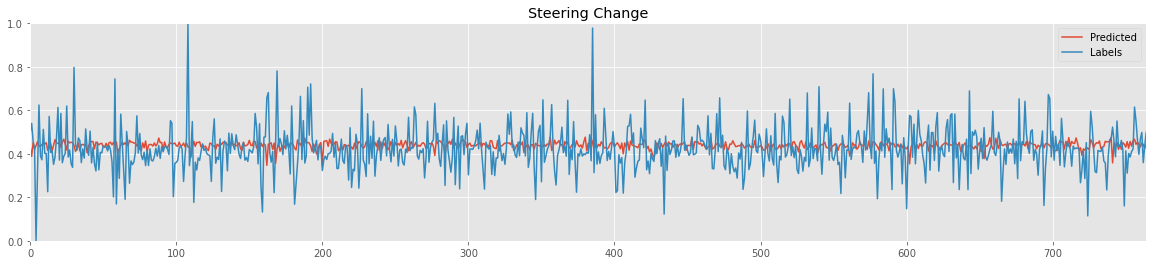

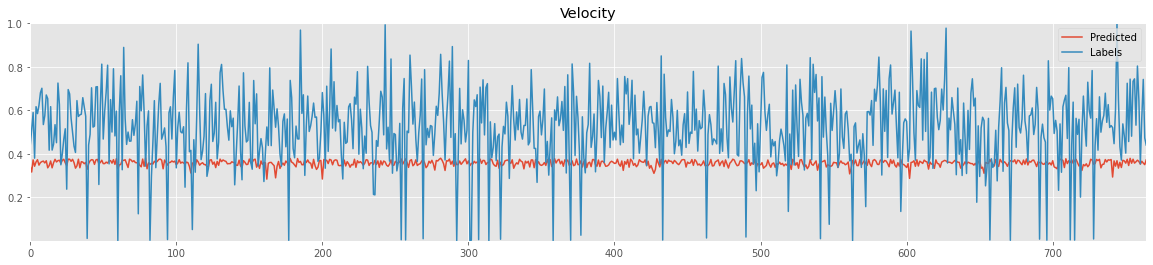

In [25]:
# ------------------RUN TEST DATA----------------------
import torch
import torchvision
from PIL import Image, ImageDraw
import numpy as np
from torchvision import datasets, transforms

NUM_SAMPLES = 5
print("Running Test Dataset")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PATH = "ae3_toBasic.pt"

#Load saved model
model = torch.load(PATH)
torch.no_grad()
model.eval()
model.to(device)


#---------------------------------------
#Load saved autoencoder model
if RUN_WITH_AE:
    ae = torch.load(AE_PATH)
    ae.eval()
    ae.to(device)
#---------------------------------------

# totalTestLoss = 0

runningLblSteer = []
runningLblVel = []
runningPredSteer = []
runningPredVel = []

# switch off autograd for evaluation
with torch.no_grad():
    # set the model in evaluation mode
    model.eval()
        
    # loop over the test set
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # AE DENOISING----------------------------------
        if RUN_WITH_AE:
            recon, latents = ae(inputs)
            inputs = recon
        # ----------------------------------------------
            
        # make predictions and calculate the test loss
        pred = model(inputs)
        
        y1 = labels.detach().cpu().squeeze().numpy()
        runningLblSteer = runningLblSteer + list(y1[:,0])
        runningLblVel = runningLblVel + list(y1[:,1])
        
        y2 = pred.detach().cpu().squeeze().numpy()
        runningPredSteer = runningPredSteer + list(y2[:,0])
        runningPredVel = runningPredVel + list(y2[:,1])
        
fig = plt.figure(figsize=(20,4))
plt.plot(runningPredSteer)
plt.plot(runningLblSteer)
plt.legend(["Predicted","Labels"], loc = "upper right")
plt.title('Steering Change')
plt.margins(0)
plt.show()

fig = plt.figure(figsize=(20,4))
plt.plot(runningPredVel)
plt.plot(runningLblVel)
plt.legend(["Predicted","Labels"], loc = "upper right")
plt.title('Velocity')
plt.margins(0)
plt.show()
    


EVALUATE PERFORMANCE WITH SELECTED TEST IMAGES

NOTE: PATH variable needs to have correct filename for whatever model we're testing

In [19]:
import torch
import torchvision
from PIL import Image
# !pip install torchvision
from torchvision import datasets, transforms
# from torchvision import datapoints

print("Evaluating network with Testing Data...")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PATH = "ae3_toBasic.pt"
NUM_SAMPLES = 5

#Load saved model
model = torch.load(PATH)
torch.no_grad()
model.eval()
model.to(device)

#---------------------------------------
#Load saved autoencoder model
if RUN_WITH_AE:
    ae = torch.load(AE_PATH)
    ae.eval()
    ae.to(device)
#---------------------------------------

#Load Random Image
single_test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

ct = 1;
for inputs, labels in single_test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # AE DENOISING----------------------------------
    if RUN_WITH_AE:
        recon, latents = ae(inputs)
        inputs = recon # TOGGLE BETWEEN LATENTS & RECON, DEPENDING ON CNN USED
    # ----------------------------------------------
        
    pred = model(inputs)
    
    img = np.transpose(inputs[0], (1, 2, 0))
    plt.imshow(img)
    plt.show()
    # print(labels)    

    print("PREDICTED STEERING (de-normalized):", pred[0,0].item())
    print("ACTUAL STEERING (de-normalized): ", labels[0,0].item())
    print("PREDICTED THROTTLE: ", pred[0,1].item())
    print("ACTUAL THROTTLE: ", labels[0,1].item())
    print("=============================")
    
    if ct == NUM_SAMPLES: break
    ct += 1
    
print("Evaluation Complete")

Evaluating network with Testing Data...


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.